In [2]:
import os
import sys
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import numpy as np
import pandas as pd
import datetime
import pytz
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from azureml.core import Workspace, Dataset
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Auto-reload to directly apply changes 
%load_ext autoreload
%autoreload 2

# Display all columns
pd.set_option("display.max_columns", None)

In [4]:
WORKDIR = os.getcwd()
DATADIR = os.path.join(WORKDIR, 'data')

# Import data

In [5]:
def load_dataset(filename):
    # Load data
    df = pd.read_csv(filename)
    df = df.set_index("data_index_")

    # Set timezone
    df.index = pd.to_datetime(df.index).tz_convert("Europe/Amsterdam")
    return df

In [6]:
load_actuals = load_dataset(os.path.join(DATADIR, 'load_actuals.csv'))
weather = load_dataset(os.path.join(DATADIR, 'weather.csv'))
wind_solar_predictions = load_dataset(os.path.join(DATADIR, 'wind_solar_predictions.csv'))

In [7]:
# merge all three dataframes
weather_data = weather.merge(wind_solar_predictions,on='data_index_', how='outer').merge(load_actuals,on='data_index_', how='outer')

In [22]:
weather_data.head(10)

temperature  solar_ghi  solar_prediction_mw  \
data_index_                                                              
2020-01-01 01:00:00+01:00   274.989655        0.0                  0.0   
2020-01-01 01:15:00+01:00   274.925659        0.0                  0.0   
2020-01-01 01:30:00+01:00   274.861694        0.0                  0.0   
2020-01-01 01:45:00+01:00   274.797699        0.0                  0.0   
2020-01-01 02:00:00+01:00   274.423157        0.0                  0.0   
2020-01-01 02:15:00+01:00   274.383179        0.0                  0.0   
2020-01-01 02:30:00+01:00   274.343201        0.0                  0.0   
2020-01-01 02:45:00+01:00   274.303223        0.0                  0.0   
2020-01-01 03:00:00+01:00   274.266571        0.0                  0.0   
2020-01-01 03:15:00+01:00   274.233185        0.0                  0.0   

                           wind_prediction_mw  load_actuals_mw  
data_index_                                                     
2020-01-01 01:00:00+01:00           70.865426        95.756328  
2020-01-01 01:15:00+01:00           69.296785        94.836196  
2020-01-01 01:30:00+01:00           66.977409        93.798127  
2020-01-01 01:45:00+01:00           64.305715        92.162902  
2020-01-01 02:00:00+01:00           61.128262        91.506670  
2020-01-01 02:15:00+01:00           57.230368        90.651134  
2020-01-01 02:30:00+01:00           53.949524        89.609819  
2020-01-01 02:45:00+01:00           50.516558        88.333277  
2020-01-01 03:00:00+01:00           47.263374        87.394102  
2020-01-01 03:15:00+01:00           44.792534        86.625883

# Inspect data

In [9]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50497 entries, 2020-01-01 01:00:00+01:00 to 2021-06-10 02:00:00+02:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature          50497 non-null  float64
 1   solar_ghi            50497 non-null  float64
 2   solar_prediction_mw  50497 non-null  float64
 3   wind_prediction_mw   50497 non-null  float64
 4   load_actuals_mw      50497 non-null  float64
dtypes: float64(5)
memory usage: 2.3 MB


In [10]:
weather_data.isnull().sum()

temperature            0
solar_ghi              0
solar_prediction_mw    0
wind_prediction_mw     0
load_actuals_mw        0
dtype: int64

# Visualize data

In [11]:
def plot_figure_load(df):
    fig = go.Figure(
        make_subplots(
            shared_xaxes=True, vertical_spacing=0.02,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df["load_actuals_mw"],
            name="Actual",
            legendgroup="Actual",
            showlegend=True,
            line_color="green",
            opacity=0.5,
        ))
    title_text = "Energy demand"
    fig.update_layout(title={'text': title_text,
                             'y': 0.95,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      autosize=False,
                      width=800,
                      height=800,
                      paper_bgcolor='white',
                      plot_bgcolor='white'
                      )

    fig.update_yaxes(title_text="Demand [MW]", title_standoff=30, title_font=dict(size=12),
                     showgrid=True, gridcolor='lightgrey',
                     zeroline=True, zerolinecolor='lightgrey',
                     )
    fig.update_xaxes(title_text="Date",
                     showgrid=True, gridcolor='lightgrey',
                     zeroline=True, zerolinecolor='lightgrey',
                     )

    return fig

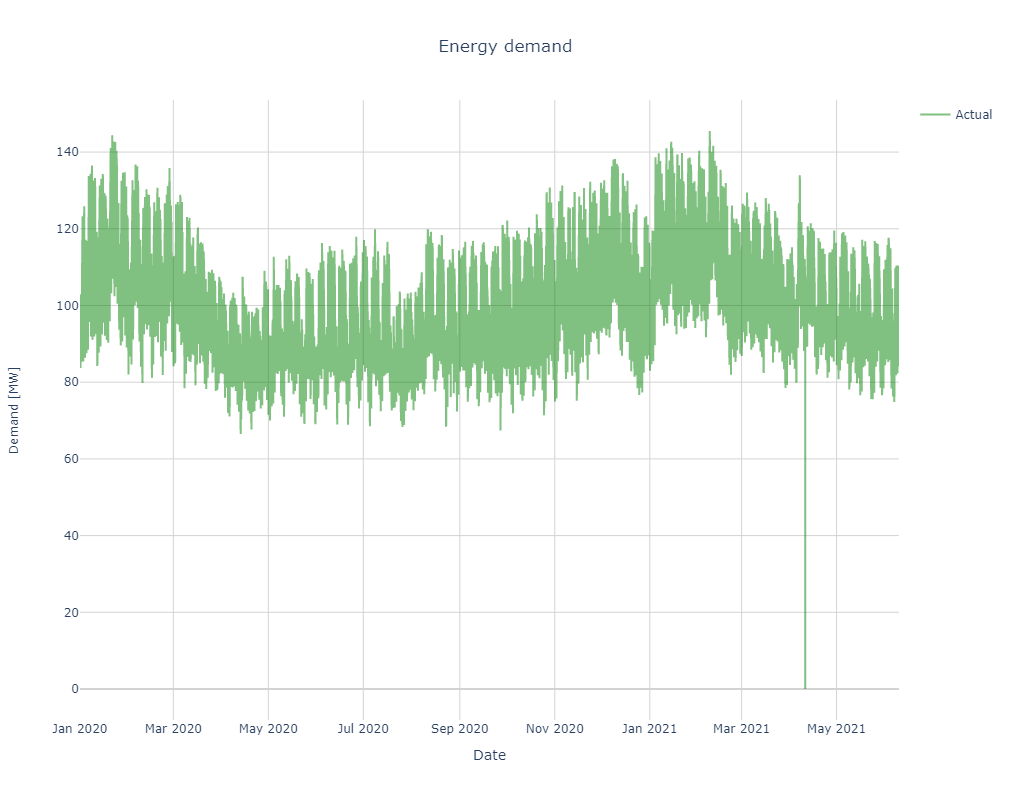

In [12]:
fig = plot_figure_load(weather_data)
fig.show()

# Data distributions

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

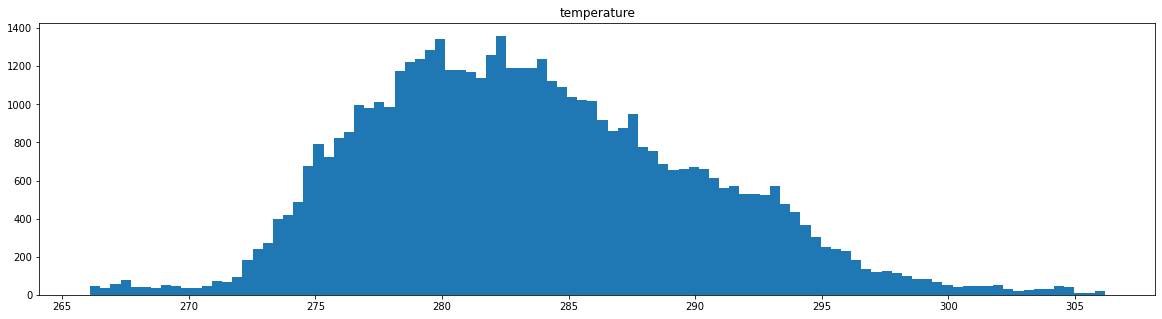

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

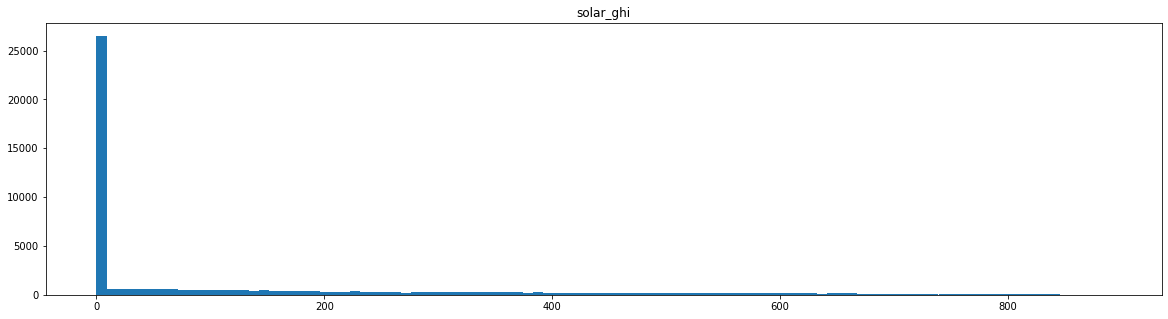

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

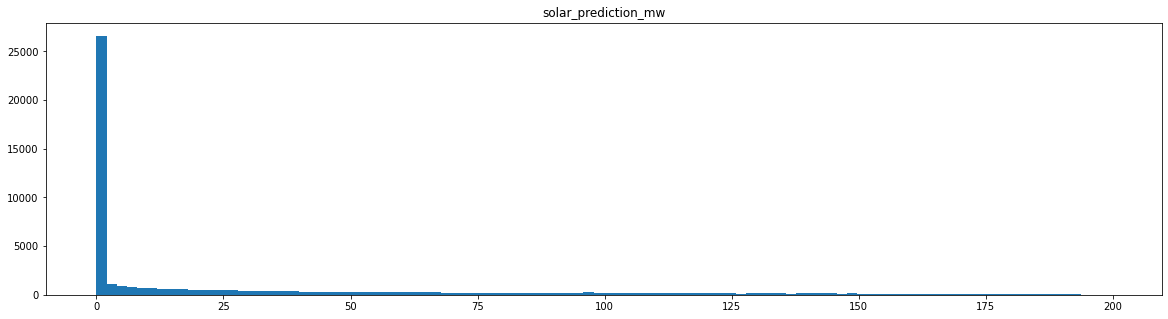

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

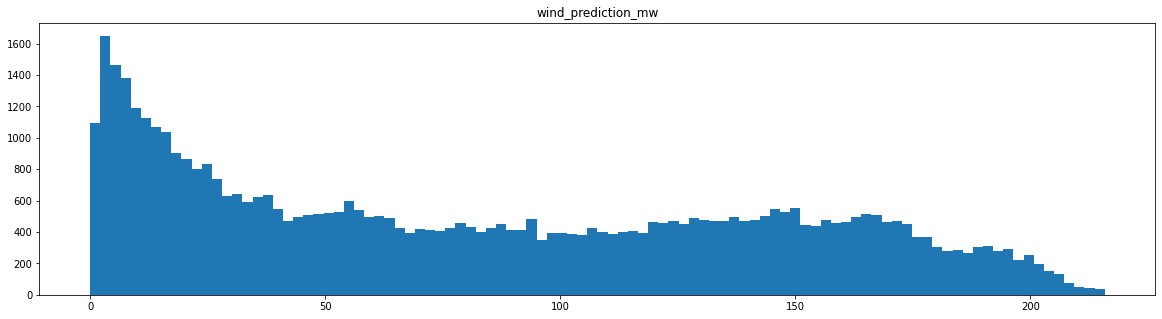

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

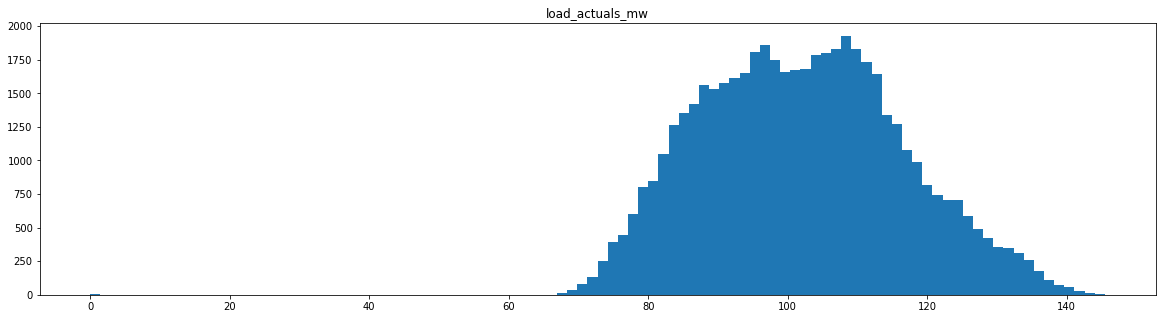

In [13]:
for column in weather_data.columns.to_list():
    plt.figure(figsize=(20,5))
    plt.hist(weather_data[column], bins=100)
    plt.title(column)
    plt.show()

In [14]:
weather_data[weather_data.load_actuals_mw == 0]

temperature  solar_ghi  solar_prediction_mw  \
data_index_                                                              
2021-04-10 20:45:00+02:00   280.404907        0.0                  0.0   
2021-04-10 21:00:00+02:00   280.318359        0.0                  0.0   
2021-04-10 21:15:00+02:00   280.232483        0.0                  0.0   
2021-04-10 21:30:00+02:00   280.146637        0.0                  0.0   
2021-04-10 21:45:00+02:00   280.060791        0.0                  0.0   
2021-04-10 22:00:00+02:00   279.974823        0.0                  0.0   
2021-04-10 22:15:00+02:00   279.888733        0.0                  0.0   
2021-04-10 22:30:00+02:00   279.802612        0.0                  0.0   

                           wind_prediction_mw  load_actuals_mw  
data_index_                                                     
2021-04-10 20:45:00+02:00          139.489594              0.0  
2021-04-10 21:00:00+02:00          140.486343              0.0  
2021-04-10 21:15:00+02:00          141.183603              0.0  
2021-04-10 21:30:00+02:00          142.101212              0.0  
2021-04-10 21:45:00+02:00          142.991407              0.0  
2021-04-10 22:00:00+02:00          143.981950              0.0  
2021-04-10 22:15:00+02:00          144.707141              0.0  
2021-04-10 22:30:00+02:00          144.997321              0.0

# Scale data (after split)

In [45]:
# scaler = MinMaxScaler()
# for column in weather_data.drop('load_actuals_mw', axis=1).columns.to_list():
#     plt.figure(figsize=(20,5))
#     plt.hist(scaler.fit_transform(weather_data[column].to_numpy().reshape(-1, 1)), bins=100)
#     plt.title(column)
#     plt.show()

# Resample data to daily average

In [62]:
weather_data_daily = weather_data.resample('D').mean()
weather_data_daily['date'] = weather_data_daily.index.date

In [63]:
weather_data_daily.head()

temperature  solar_ghi  solar_prediction_mw  \
data_index_                                                              
2020-01-01 00:00:00+01:00   274.919020  42.663104            11.562511   
2020-01-02 00:00:00+01:00   278.020686  19.332995             3.163379   
2020-01-03 00:00:00+01:00   281.066252  10.933115             1.198061   
2020-01-04 00:00:00+01:00   278.480563  33.503310             6.980235   
2020-01-05 00:00:00+01:00   278.004607  38.834253             6.731682   

                           wind_prediction_mw  load_actuals_mw        date  
data_index_                                                                 
2020-01-01 00:00:00+01:00           29.242464        92.924560  2020-01-01  
2020-01-02 00:00:00+01:00          100.044628       107.043729  2020-01-02  
2020-01-03 00:00:00+01:00          143.033258       108.116379  2020-01-03  
2020-01-04 00:00:00+01:00          103.775679       103.160229  2020-01-04  
2020-01-05 00:00:00+01:00           43.812435       102.308454  2020-01-05

In [64]:
weather_data_daily.to_csv(os.path.join(DATADIR, 'weather_data_daily.csv'), index=False)

# Register data to the workspace

In [32]:
# get the workspace from config.json
ws = Workspace.from_config()
# get the datastore to upload our data
datastore = ws.get_default_datastore()

In [65]:
datastore.upload_files([os.path.join(DATADIR, 'weather_data_daily.csv')], target_path='data', overwrite=True)

Uploading an estimated of 1 files
Uploading D:\DS\MLOps-Bootcamp-2021\MLOps-Bootcamp-2021\data\weather_data_daily.csv
Uploaded D:\DS\MLOps-Bootcamp-2021\MLOps-Bootcamp-2021\data\weather_data_daily.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_b5bb214447b74c9ab6c45f107ee255f9

In [66]:
processed_weather_data = Dataset.Tabular.from_delimited_files(datastore.path('data/weather_data_daily.csv'))

In [67]:
processed_weather_data = processed_weather_data.register(workspace=ws, name="weather_data_daily", description="processed PyTown energy demand daily average")